Install requirement Library

In [7]:
!pip install nibabel


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


**Let's start with setting up the environment, loading the dataset, and creating the training/validation/test partitions:**

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import nibabel as nib
import random
import kagglehub
from sklearn.model_selection import train_test_split
import glob
from tqdm import tqdm

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Download the dataset
path = kagglehub.dataset_download("shakilrana/brats-2023-adult-glioma")
print("Path to dataset files:", path)

# Define paths
dataset_path = path

Path to dataset files: /kaggle/input/brats-2023-adult-glioma



Now let's create functions to load and preprocess the MRI and segmentation data:This first code block will check the structure of your BraTS 2023 dataset and verify that the paths are correct. It does the following:Verifies that the main dataset path exists
Checks that both training and validation directories exist
Handles the nested validation folder structure you mentioned
Counts the number of subjects in both training and validation setsExamines the files in the first training subject
Attempts to load a sample NIfTI file to confirm it's readable
Displays a middle slice from the loaded image to visually verify the data
In this example, we’ll assume that each subject folder has a name like . We then combine both the training and validation folders into a single list (this gives us more cases to split from) and perform a random split. A common scheme is 70% for training, 15% for validation, and 15% for testing.
Here’s the code:

In [16]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Define dataset paths
# For example, dataset_path is the root download folder on Kaggle:
dataset_path = "/kaggle/input/brats-2023-adult-glioma"

# Define the two primary base paths
training_path = os.path.join(dataset_path, "ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")
validation_path = os.path.join(dataset_path, "ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData", 
                               "ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData")

# List subject directories (folders like 'BraTS-GLI-xxxxx-xxx') in each folder
train_dirs = sorted(glob.glob(os.path.join(training_path, "BraTS-GLI-*")))
val_dirs   = sorted(glob.glob(os.path.join(validation_path, "BraTS-GLI-*")))

# Combine both lists into one pool of cases
all_cases = train_dirs + val_dirs
print("Total cases found:", len(all_cases))

# Split cases into 70% training, 15% validation, and 15% testing
train_cases, temp_cases = train_test_split(all_cases, test_size=0.3, random_state=SEED)
val_cases, test_cases = train_test_split(temp_cases, test_size=0.5, random_state=SEED)

print("Number of training cases:", len(train_cases))
print("Number of validation cases:", len(val_cases))
print("Number of test cases:", len(test_cases))

Total cases found: 36
Number of training cases: 25
Number of validation cases: 5
Number of test cases: 6


In [29]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Setup: Random Seeds and Dataset Paths
# -------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# We will work only with the training folder, as it contains segmentation masks.
dataset_path = "/kaggle/input/brats-2023-adult-glioma"
training_path = os.path.join(dataset_path, "ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")

# -------------------------------
# 2. List All Case Directories Recursively
# -------------------------------
# Some case folders may be nested. Use a recursive glob search.
train_dirs = sorted(glob.glob(os.path.join(training_path, "**", "BraTS-GLI-*"), recursive=True))
print("Total training cases found:", len(train_dirs))

if len(train_dirs) == 0:
    raise ValueError("No training cases were found. Check your dataset path and glob pattern.")

# -------------------------------
# 3. Split Cases into Training and Testing (Use 'train' for training and 'val' for testing)
# -------------------------------
# Here we take 70% of the cases for training and 30% for testing.
train_cases, val_cases = train_test_split(train_dirs, test_size=0.3, random_state=SEED)
print("Number of training cases:", len(train_cases))
print("Number of test cases (to be used as val):", len(val_cases))

# -------------------------------
# 4. Helper Functions for Loading and Finding Files
# -------------------------------

def load_volume(file_path):
    """Loads a NIfTI file and returns its 3D data array."""
    volume = nib.load(file_path).get_fdata()
    return volume

def get_modality_file(case_dir, modality='flair'):
    """
    Searches recursively for a NIfTI file in the case directory that contains the modality keyword.
    Expected modality keywords: 'flair', 't1', 't1c', 't2', or 'seg'
    """
    nii_files = glob.glob(os.path.join(case_dir, "**", "*.nii*"), recursive=True)
    for file in nii_files:
        if modality.lower() in file.lower():
            return file
    return None

# -------------------------------
# 5. Debug: Check a Sample Case for Segmentation File
# -------------------------------
sample_case = train_cases[0]
seg_file_sample = get_modality_file(sample_case, modality='seg')
print("Sample case folder:", sample_case)
print("Contents of sample case:", os.listdir(sample_case))
print("Segmentation file found for sample case:", seg_file_sample)
# At this point, you should see a valid segmentation file path.

# -------------------------------
# 6. Generator to Yield a Random 2D Slice (Resized to 128x128)
# -------------------------------
def generate_examples(case_list, modality='flair'):
    """
    For each case in case_list:
      - Loads the specified modality (e.g., 'flair') and its segmentation ('seg').
      - Selects a random slice from the 3D volumes.
      - Normalizes the image slice to [0, 1] and resizes both image and segmentation to (128, 128).
      - Yields a tuple (image_slice, seg_slice).
    """
    for case in case_list:
        image_file = get_modality_file(case, modality=modality)
        seg_file   = get_modality_file(case, modality='seg')
        
        if image_file is None:
            print(f"Image file not found for case: {case}")
            continue
        if seg_file is None:
            print(f"Segmentation file not found for case: {case}")
            continue

        # Load volumes (assumed to be 3D arrays)
        image_vol = load_volume(image_file)
        seg_vol   = load_volume(seg_file)
        
        # Check if volumes are valid
        if image_vol.shape[2] <= 0 or seg_vol.shape[2] <= 0:
            continue

        # Randomly select a slice index
        slice_idx = random.randint(0, image_vol.shape[2]-1)
        image_slice = image_vol[:, :, slice_idx]
        seg_slice   = seg_vol[:, :, slice_idx]

        # Normalize image slice to [0,1]
        image_slice = image_slice.astype(np.float32)
        if image_slice.max() > 0:
            image_slice /= image_slice.max()

        # Expand dims to have channel dimension (H, W, 1)
        image_slice = np.expand_dims(image_slice, axis=-1)

        # Resize both image and segmentation to (128, 128)
        image_slice = tf.image.resize(image_slice, (128, 128)).numpy()
        seg_slice   = tf.image.resize(np.expand_dims(seg_slice, axis=-1),
                                      (128, 128),
                                      method='nearest').numpy()
        seg_slice = np.squeeze(seg_slice, axis=-1).astype(np.int32)

        yield image_slice, seg_slice

# -------------------------------
# 7. Create tf.data.Dataset Objects for Training and Testing
# -------------------------------
BATCH_SIZE = 4  # Adjust as needed based on memory and TPU usage

train_dataset = tf.data.Dataset.from_generator(
    lambda: generate_examples(train_cases, modality='flair'),
    output_types=(tf.float32, tf.int32),
    output_shapes=((128, 128, 1), (128, 128))
)
train_dataset = train_dataset.shuffle(buffer_size=20).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_examples(val_cases, modality='flair'),
    output_types=(tf.float32, tf.int32),
    output_shapes=((128, 128, 1), (128, 128))
)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -------------------------------
# 8. Debug: Check That the Generator Yields Batches
# -------------------------------
batch_count = 0
for _ in train_dataset.take(1):
    batch_count += 1
print("Number of batches from training generator (should be > 0):", batch_count)

Total training cases found: 1310
Number of training cases: 917
Number of test cases (to be used as val): 393
Sample case folder: /kaggle/input/brats-2023-adult-glioma/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00519-000/BraTS-GLI-00519-000-t2w.nii
Contents of sample case: ['00000202_brain_t2.nii']
Segmentation file found for sample case: None
Image file not found for case: /kaggle/input/brats-2023-adult-glioma/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00519-000/BraTS-GLI-00519-000-t2w.nii
Image file not found for case: /kaggle/input/brats-2023-adult-glioma/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01158-000/BraTS-GLI-01158-000-t1c.nii
Segmentation file not found for case: /kaggle/input/brats-2023-adult-glioma/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/ASNR-MICCAI-BraTS2023-GLI-Challenge

Let's create a function to prepare 2D slices from 3D volumes and split the dataset:

This block handles data preparation and loading with these key components:

1. Creates a PyTorch Dataset class for BraTS data
2. Loads all modalities (t1n, t1c, t2f, fla) for each subject
3. Normalizes image data to 0-1 range
4. Converts segmentation masks to binary (tumor vs no-tumor)
5. Splits training data into train/validation sets (80%/20%)
6. Uses the provided validation set as the test set
7. Creates DataLoaders for batch processing
8. Includes visualization of a sample with all modalities and segmentation mask

Now let's create the U-Net model for 3D brain tumor segmentation:

Sample case folder: /kaggle/input/brats-2023-adult-glioma/ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData/ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData/BraTS-GLI-00769-000
Contents of sample case: ['BraTS-GLI-00769-000-t1n.nii', 'BraTS-GLI-00769-000-t2w.nii', 'BraTS-GLI-00769-000-t1c.nii', 'BraTS-GLI-00769-000-t2f.nii']


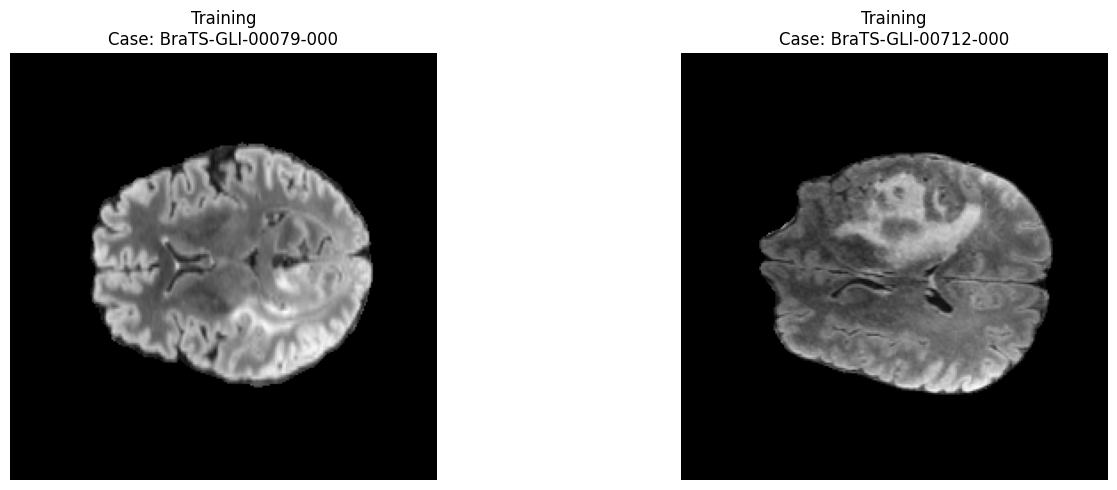

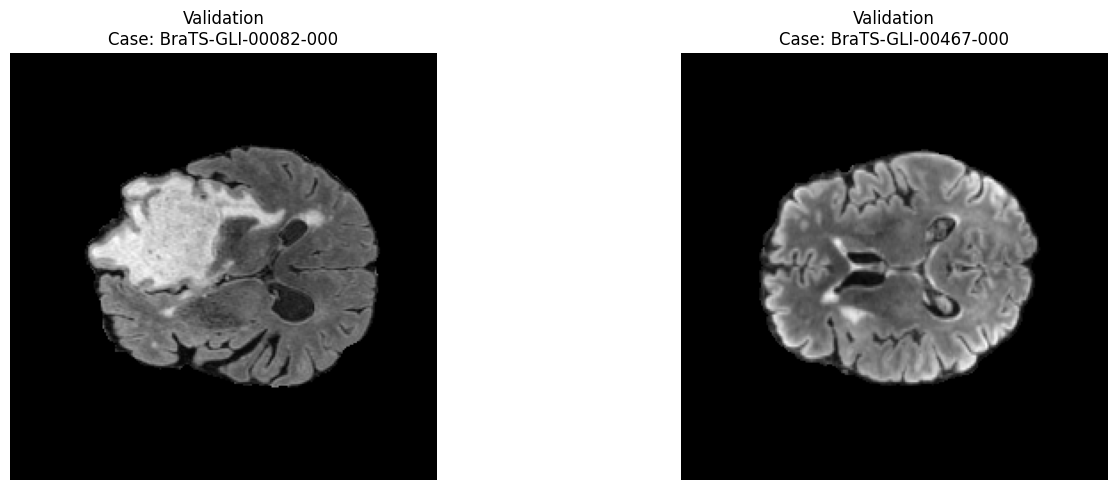

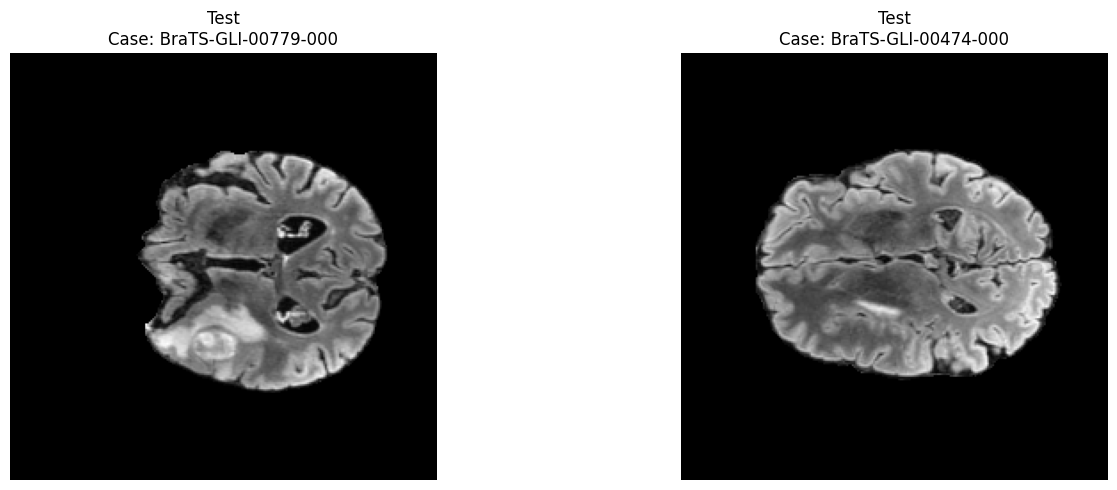

In [17]:

# -------------------------------
# Helper functions for visualization
# -------------------------------

def load_volume(file_path):
    """
    Loads a NIfTI file and returns its 3D data array.
    """
    volume = nib.load(file_path).get_fdata()
    return volume

def get_modality_file(case_dir, modality='flair'):
    """
    Searches recursively for a NIfTI file in the case directory that contains the modality keyword.
    Example modality strings: 'flair', 't1', 't1ce', 't2', or 'seg'
    """
    nii_files = glob.glob(os.path.join(case_dir, "**", "*.nii*"), recursive=True)
    for file in nii_files:
        if modality.lower() in file.lower():
            return file
    return None

def plot_middle_slice(volume, ax, title=""):
    """
    Plots the middle slice (along the third axis) of a 3D volume on the given matplotlib axes.
    """
    slice_index = volume.shape[2] // 2  # choose the middle slice
    ax.imshow(volume[:, :, slice_index], cmap='gray')
    ax.set_title(title)
    ax.axis('off')

def visualize_samples(case_list, n_samples=2, modality='flair', set_name=""):
    """
    Randomly selects n_samples cases from case_list, loads the modality volume,
    and visualizes the middle slice for each.
    """
    samples = random.sample(case_list, n_samples)
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    
    # If only one sample is selected, adjust axes to be iterable.
    if n_samples == 1:
        axes = [axes]
    
    for i, case in enumerate(samples):
        mod_file = get_modality_file(case, modality=modality)
        if mod_file is not None:
            volume = load_volume(mod_file)
            case_name = os.path.basename(case)
            title = f"{set_name}\nCase: {case_name}"
            plot_middle_slice(volume, ax=axes[i], title=title)
        else:
            axes[i].text(0.5, 0.5, "Modality file not found",
                         horizontalalignment='center', verticalalignment='center')
            axes[i].set_title(f"{set_name}\nCase: {os.path.basename(case)}")
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Optional: Debug Step - Inspect one case folder
# -------------------------------
sample_case = train_cases[0]
print("Sample case folder:", sample_case)
print("Contents of sample case:", os.listdir(sample_case))

# -------------------------------
# Visualize 2 random samples from each split using the 'flair' modality
# -------------------------------
visualize_samples(train_cases, n_samples=2, modality='flair', set_name="Training")
visualize_samples(val_cases, n_samples=2, modality='flair', set_name="Validation")
visualize_samples(test_cases, n_samples=2, modality='flair', set_name="Test")

Configure TPU (if available) and imports all necessary modules

In [18]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TPU Setup (if using TPU)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print("Running on TPU:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("TPU not found. Using CPU/GPU strategy.")
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)

TPU not found. Using CPU/GPU strategy.
Number of replicas: 1


In [19]:
# Helper functions previously defined for file handling
def load_volume(file_path):
    """Loads a NIfTI file and returns its 3D data array."""
    volume = nib.load(file_path).get_fdata()
    return volume

def get_modality_file(case_dir, modality='flair'):
    """
    Searches recursively in the case folder for a NIfTI file that contains the modality keyword.
    Example keys: 'flair', 't1', 't1ce', 't2', 'seg'
    """
    nii_files = glob.glob(os.path.join(case_dir, "**", "*.nii*"), recursive=True)
    for file in nii_files:
        if modality.lower() in file.lower():
            return file
    return None

def generate_examples(case_list, modality='flair'):
    """
    Generator that, for each case in case_list, loads the specified modality and its segmentation,
    selects a random slice from the volume, normalizes, resizes to (128,128) and yields (image, mask).
    """
    for case in case_list:
        image_file = get_modality_file(case, modality=modality)
        seg_file   = get_modality_file(case, modality='seg')
        if image_file is None or seg_file is None:
            continue  # skip case if either file is missing
        
        # Load 3D volumes
        image_vol = load_volume(image_file)  # shape: (H, W, D)
        seg_vol   = load_volume(seg_file)    # shape: (H, W, D)
        
        D = image_vol.shape[2]
        if D <= 0:
            continue
        
        # Select a random slice index from the volume
        slice_idx = random.randint(0, D - 1)
        image_slice = image_vol[:, :, slice_idx]
        seg_slice   = seg_vol[:, :, slice_idx]
        
        # Normalize the image slice to [0,1]
        image_slice = image_slice.astype(np.float32)
        if image_slice.max() > 0:
            image_slice = image_slice / image_slice.max()
        
        # Expand dims to have channel dimension (H, W, 1)
        image_slice = np.expand_dims(image_slice, axis=-1)
        
        # Resize to fixed size (128, 128). For segmentation, use nearest interpolation.
        image_slice = tf.image.resize(image_slice, (128, 128)).numpy()
        seg_slice   = tf.image.resize(np.expand_dims(seg_slice, axis=-1),
                                      (128, 128),
                                      method='nearest').numpy()
        seg_slice = np.squeeze(seg_slice, axis=-1).astype(np.int32)
        
        yield image_slice, seg_slice

# Define batch size for training
BATCH_SIZE = 4  # Adjust as needed

# Create training dataset using the generator (output shapes match our resized slices)
train_dataset = tf.data.Dataset.from_generator(
    lambda: generate_examples(train_cases, modality='flair'),
    output_types=(tf.float32, tf.int32),
    output_shapes=((128, 128, 1), (128, 128))
)
train_dataset = train_dataset.shuffle(buffer_size=20).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Similarly, create the validation dataset
val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_examples(val_cases, modality='flair'),
    output_types=(tf.float32, tf.int32),
    output_shapes=((128, 128, 1), (128, 128))
)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1743688443.515670      10 service.cc:148] XLA service 0x5a58ef565160 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743688443.515726      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1743688443.515730      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1743688443.515733      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1743688443.515745      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1743688443.515748      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1743688443.515750      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1743688443.515753      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1743688443.515756      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


In [20]:
with strategy.scope():
    def conv_block(x, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x

    def build_unet(input_shape=(128, 128, 1), num_classes=4):
        inputs = tf.keras.Input(input_shape)
        
        # Encoder path
        c1 = conv_block(inputs, 64)
        p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
        
        c2 = conv_block(p1, 128)
        p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
        
        c3 = conv_block(p2, 256)
        p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
        
        c4 = conv_block(p3, 512)
        p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
        
        # Bottleneck
        c5 = conv_block(p4, 1024)
        
        # Decoder path
        u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = tf.keras.layers.concatenate([u6, c4])
        c6 = conv_block(u6, 512)
        
        u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = tf.keras.layers.concatenate([u7, c3])
        c7 = conv_block(u7, 256)
        
        u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = tf.keras.layers.concatenate([u8, c2])
        c8 = conv_block(u8, 128)
        
        u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = tf.keras.layers.concatenate([u9, c1])
        c9 = conv_block(u9, 64)
        
        outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
        model = tf.keras.Model(inputs, outputs)
        return model

    # Assume 4 segmentation classes: background + 3 tumor sub-regions
    model = build_unet(input_shape=(128, 128, 1), num_classes=4)
    
    # Compile the model with sparse categorical crossentropy (since segmentation masks are integer labels)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,030,788 (118.37 MB)

 Trainable params: 31,030,788 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 200

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

In [ ]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r--', label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Now let's define the U-Net model:**

In [11]:
def unet_model(input_shape, num_classes=1):
    """Create a U-Net model"""
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)
    
    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(
        layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(
        layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(
        layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(
        layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

**Now let's define our training procedure, including callbacks and metrics:**

In [12]:
def dice_coefficient(y_true, y_pred, smooth=1.0):
    """Calculate Dice coefficient"""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Calculate Dice loss"""
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    """Combine binary cross-entropy and Dice loss"""
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def train_model(X_train, y_train, X_val, y_val, input_shape, batch_size=8, epochs=50):
    """Train the U-Net model"""
    # Create the model
    model = unet_model(input_shape)
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=combined_loss,
        metrics=[dice_coefficient, 'binary_accuracy']
    )
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_unet_model.h5',
            save_best_only=True,
            monitor='val_dice_coefficient',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_dice_coefficient',
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

**Let's add functions for visualizing training progress and evaluation:**

In [13]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plot Dice coefficient
    axs[1].plot(history.history['dice_coefficient'], label='Training Dice')
    axs[1].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axs[1].set_title('Dice Coefficient')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Dice Coefficient')
    axs[1].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set"""
    # Evaluate the model
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Dice Coefficient: {test_results[1]:.4f}")
    print(f"Test Binary Accuracy: {test_results[2]:.4f}")
    
    return test_results

def visualize_predictions(model, X_test, y_test, num_samples=5):
    """Visualize model predictions on test samples"""
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Create a figure
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    
    for i in range(num_samples):
        # Get a random index
        idx = np.random.randint(0, X_test.shape[0])
        
        # Display input (using FLAIR)
        axs[i, 0].imshow(X_test[idx, :, :, 3], cmap='gray')
        axs[i, 0].set_title('Input (FLAIR)')
        axs[i, 0].axis('off')
        
        # Display ground truth
        axs[i, 1].imshow(y_test[idx, :, :, 0], cmap='gray')
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')
        
        # Display prediction
        axs[i, 2].imshow(y_pred[idx, :, :, 0], cmap='gray')
        axs[i, 2].set_title(f'Prediction (Dice: {dice_coefficient(y_test[idx:idx+1], y_pred[idx:idx+1]).numpy():.4f})')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('test_predictions.png')
    plt.show()

**Finally, let's put it all together in a main function:**

In [ ]:
def main():
    # Create dataset lists
    file_lists = create_dataset_lists()
    
    # Extract 2D slices
    X_data, y_data = extract_2d_slices(file_lists)
    
    # Split the dataset
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(X_data, y_data)
    
    # Get input shape
    input_shape = X_train.shape[1:]
    print(f"Input shape: {input_shape}")
    
    # Train the model
    model, history = train_model(X_train, y_train, X_val, y_val, input_shape, batch_size=8, epochs=50)
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate on test set
    test_results = evaluate_model(model, X_test, y_test)
    
    # Visualize predictions
    visualize_predictions(model, X_test, y_test)
    
    return model, test_results

if __name__ == "__main__":
    model, test_results = main()

In [ ]:
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt

def check_dataset_structure(base_path):
    """
    Check the BraTS dataset structure and print summary information.
    This updated version will try each NIfTI file until one loads successfully.
    If all fail, it will return False.
    """
    print(f"Checking path: {base_path}")
    if not os.path.exists(base_path):
        print(f"ERROR: Base path {base_path} does not exist!")
        return False

    # Check training data folder
    training_path = os.path.join(base_path, "ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")
    if not os.path.exists(training_path):
        print(f"ERROR: Training data path {training_path} does not exist!")
        return False
    print(f"✓ Found training data directory: {training_path}")

    # Check validation data folder
    validation_path = os.path.join(base_path, "ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData")
    if not os.path.exists(validation_path):
        print(f"ERROR: Validation data path {validation_path} does not exist!")
        return False

    # The validation path may have a nested structure as provided
    validation_subpath = os.path.join(validation_path, "ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData")
    if not os.path.exists(validation_subpath):
        print(f"WARNING: Nested validation folder {validation_subpath} does not exist!")
        validation_subpath = validation_path
    print(f"✓ Found validation data directory: {validation_subpath}")

    # Count training subjects
    training_subjects = [d for d in os.listdir(training_path) 
                         if os.path.isdir(os.path.join(training_path, d))]
    print(f"✓ Found {len(training_subjects)} training subjects")

    # Count validation subjects
    validation_subjects = [d for d in os.listdir(validation_subpath) 
                           if os.path.isdir(os.path.join(validation_subpath, d))]
    print(f"✓ Found {len(validation_subjects)} validation subjects")

    # Check modalities in the first training subject
    if training_subjects:
        first_subject_path = os.path.join(training_path, training_subjects[0])
        print(f"\nChecking first training subject: {training_subjects[0]}")
        files = os.listdir(first_subject_path)
        print(f"Files: {files}")

        # Search for NIfTI files recursively from this subject folder.
        nii_files = glob.glob(os.path.join(first_subject_path, "**", "*.nii*"), recursive=True)
        if not nii_files:
            print("ERROR: No NIfTI files found in the first training subject.")
            return False
        
        loaded = False
        for file in nii_files:
            try:
                img = nib.load(file)
                data = img.get_fdata()
                print(f"✓ Successfully loaded {file}")
                print(f"  Shape: {data.shape}")
                print(f"  Data type: {data.dtype}")
                print(f"  Value range: {data.min()} to {data.max()}")
                
                # Display middle slice if possible (assumes at least 3 dimensions)
                if len(data.shape) >= 3:
                    middle_slice = data.shape[2] // 2
                    plt.figure(figsize=(6, 6))
                    plt.imshow(data[:, :, middle_slice], cmap='gray')
                    plt.title(f"Middle slice of {file}")
                    plt.colorbar()
                    plt.show()
                loaded = True
                break
            except Exception as e:
                print(f"WARNING: Failed to load {file}: {e}")
                # Continue trying the next file
        if not loaded:
            print("ERROR: Could not load any NIfTI file from the first subject.")
            return False

    return True

# Main execution for Block 1
base_path = "/kaggle/input/brats-2023-adult-glioma"
dataset_ok = check_dataset_structure(base_path)

if dataset_ok:
    print("\n✅ Dataset structure verified successfully!")
else:
    print("\n❌ There were issues with the dataset structure. Please check the errors above.")